In [18]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats

# Dataset

In [19]:
jerks_path = "Dataset/Human_Likeness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Human_Likeness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Human_Likeness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

labels_path = "Dataset/Human_Likeness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [20]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})

XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['idx'] = XY['StudySeq']

# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)
XY.set_index('idx', inplace=True)
print(XY.shape) # Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + Label for MOS = 120

(320, 120)


In [21]:
XX = XY.drop(['Mean_Human_Likeness_Score'], axis=1, inplace=False)
YY = XY.loc[:,'Mean_Human_Likeness_Score']
XX = np.log(XX)
print(XX.shape)
print(YY.shape)

(320, 119)
(320,)


107.12149997827616


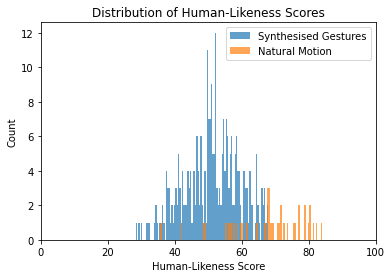

In [22]:
plt.hist(YY.loc[np.array(['Cond_N' not in idx for idx in YY.index])], bins = 100, label='Synthesised Gestures', alpha=0.7)
plt.hist(YY.loc[['Cond_N' in idx for idx in YY.index]], bins = 100, label='Natural Motion', alpha=0.7)

plt.xlim(0,100)
plt.xlabel("Human-Likeness Score")
plt.ylabel("Count")
plt.title("Distribution of Human-Likeness Scores")
plt.legend()
var = np.var(YY)
print(var)

107.12149997827616


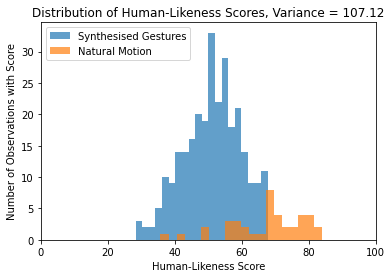

In [23]:
plt.hist(YY.loc[np.array(['Cond_N' not in idx for idx in YY.index])], bins = 20, label='Synthesised Gestures', alpha=0.7)
plt.hist(YY.loc[['Cond_N' in idx for idx in YY.index]], bins = 20, label='Natural Motion', alpha=0.7)

plt.xlim(0,100)
plt.xlabel("Human-Likeness Score")
plt.ylabel("Number of Observations with Score")
plt.title("Distribution of Human-Likeness Scores, Variance = " + str(round(np.var(YY),2)))
plt.legend()
var = np.var(YY)
print(var)

Sort features in terms of correlation between Human-Likeness and Feature

In [7]:
pcc_vals = []
for i in XX.columns:
    rho, pval = stats.spearmanr(XX[i], YY)
    pcc_vals = pcc_vals + [rho]

abs_pcc_vals = np.abs(pcc_vals)
sorted_abs_pcc_vals = np.sort(abs_pcc_vals)

sorted_features = []
for i in sorted_abs_pcc_vals:
    feature_index = np.where(abs_pcc_vals == i)
    sorted_features = sorted_features + [XX.columns[feature_index]]

print("Feature with Highest Correlation: ", sorted_features[-1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-1][0])[0][0]])
print("Feature with 2nd Highest Correlation: ", sorted_features[-2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-2][0])[0][0]])
print("Feature with 3rd Highest Correlation: ", sorted_features[-3][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-3][0])[0][0]])
print("Feature with 3rd Lowest Correlation: ", sorted_features[2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[2][0])[0][0]])
print("Feature with 2nd Lowest Correlation: ", sorted_features[1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[1][0])[0][0]])
print("Feature with Lowest Correlation: ", sorted_features[0][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[0][0])[0][0]])

print("Mean Feature PCC (absolute): ", np.mean(sorted_abs_pcc_vals), "with stdev: ", np.std(sorted_abs_pcc_vals))

Feature with Highest Correlation:  LeftHand_jerks  - PCC = -0.33037383015003124
Feature with 2nd Highest Correlation:  RightHand_jerks  - PCC = -0.3205314434701379
Feature with 3rd Highest Correlation:  Neck_vs_Neck1  - PCC = -0.27952337064986055
Feature with 3rd Lowest Correlation:  Spine3_accels  - PCC = -0.009729775655035995
Feature with 2nd Lowest Correlation:  LeftShoulder_vs_RightShoulder  - PCC = 0.007316185704941536
Feature with Lowest Correlation:  LeftArm_vs_LeftForeArm  - PCC = -0.0037854131200096156
Mean Feature PCC (absolute):  0.12069101282001599 with stdev:  0.07028807390678986


Text(0.5, 1.0, 'Distribution of Feature PCCs')

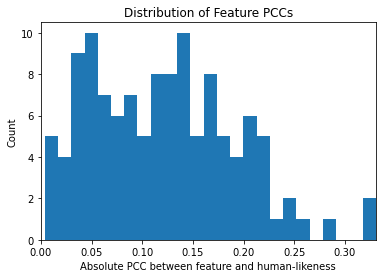

In [8]:
bins = 25
plt.hist(abs_pcc_vals, bins = bins)
plt.xlim(0,max(abs_pcc_vals))
plt.xlabel("Absolute PCC between feature and human-likeness")
plt.ylabel("Count")
plt.title("Distribution of Feature PCCs")

Plots of Highest and Lowest Correlated Features vs Human-Likeness Scores

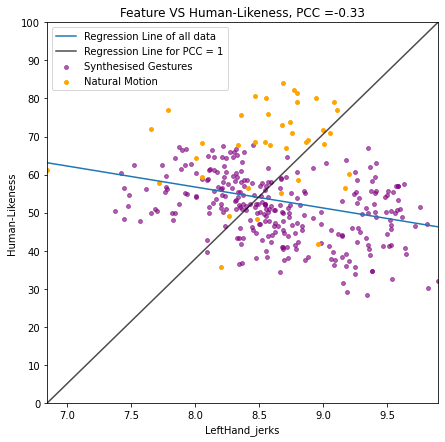

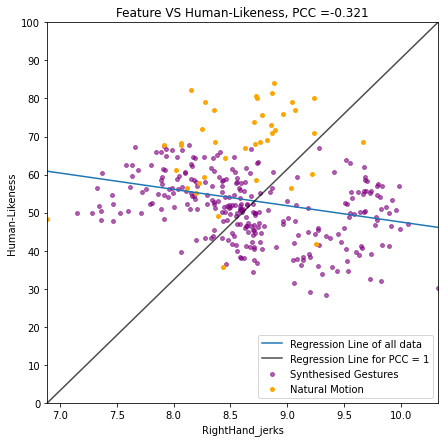

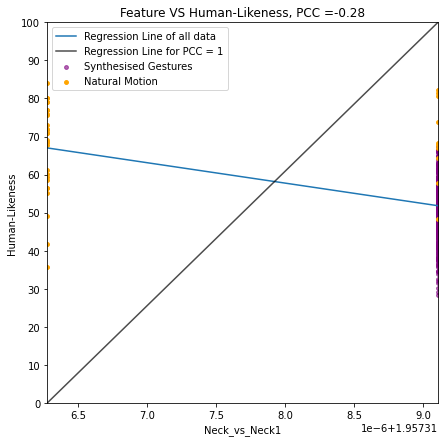

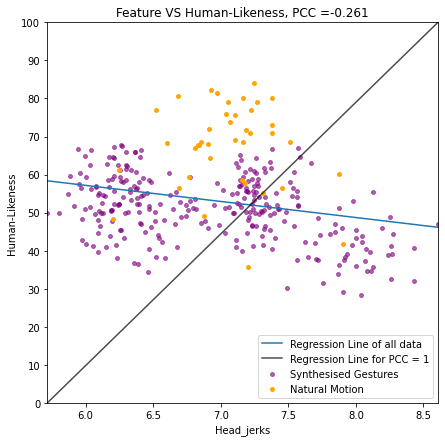

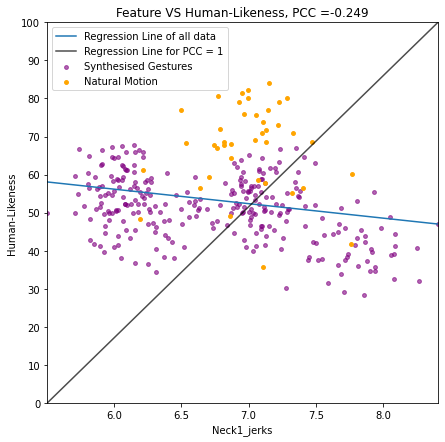

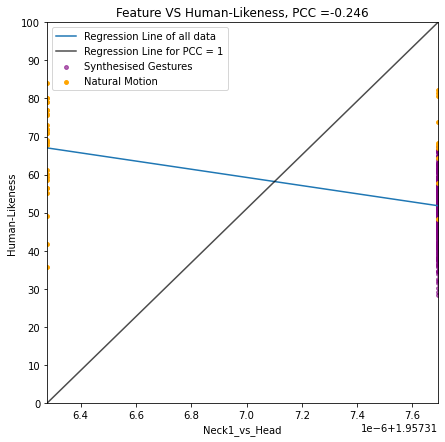

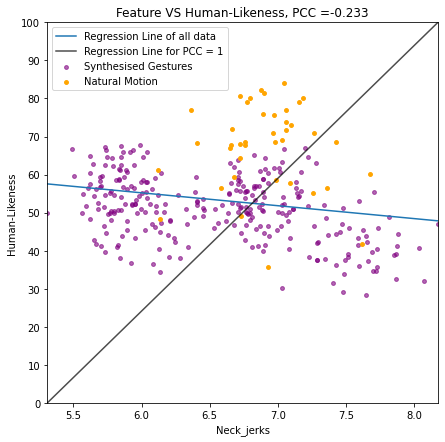

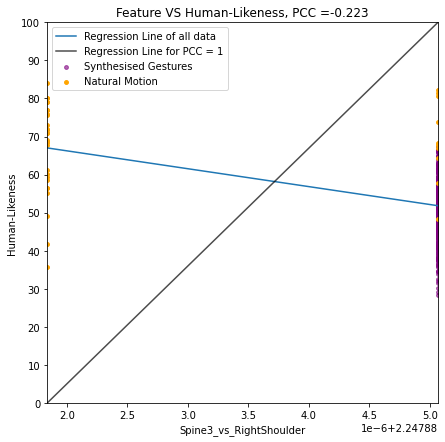

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


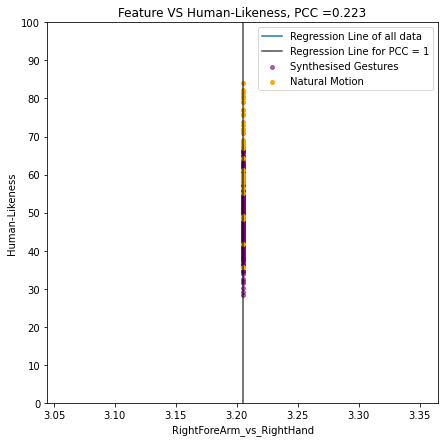

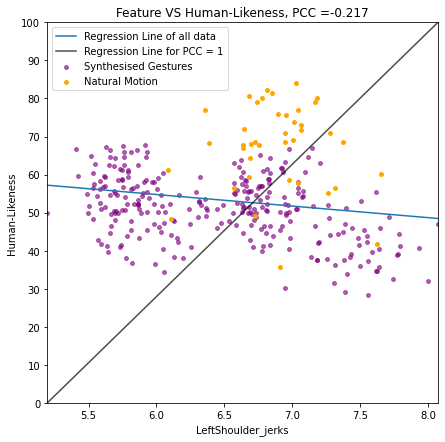

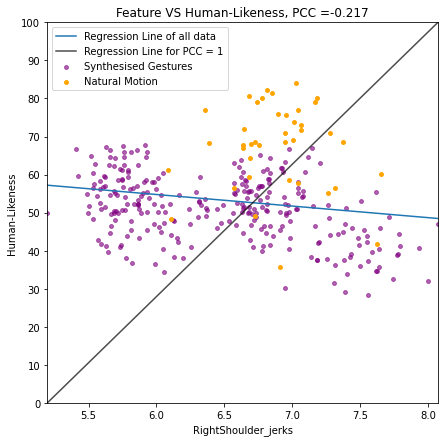

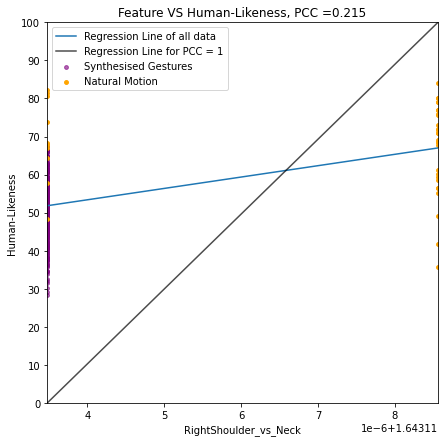

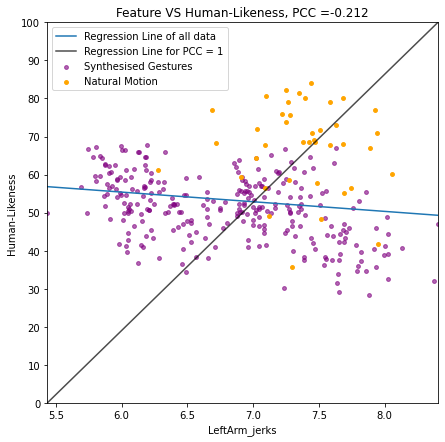

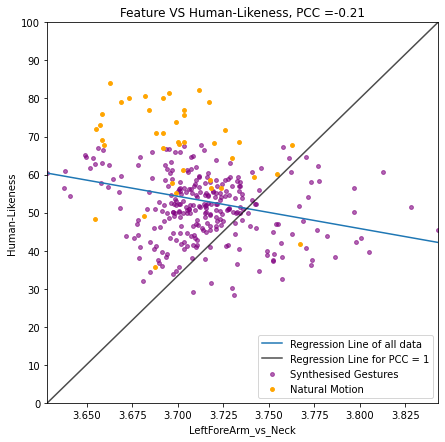

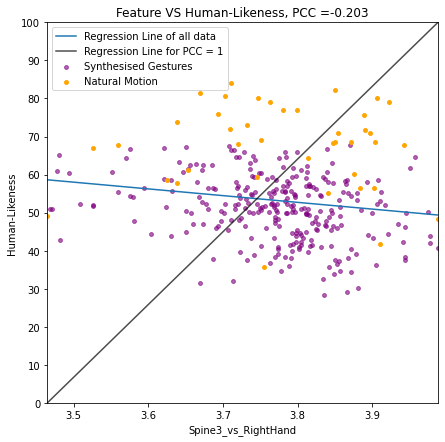

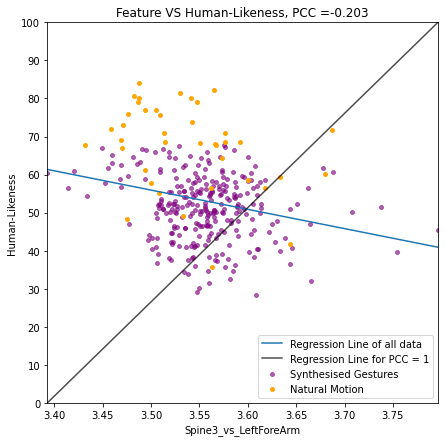

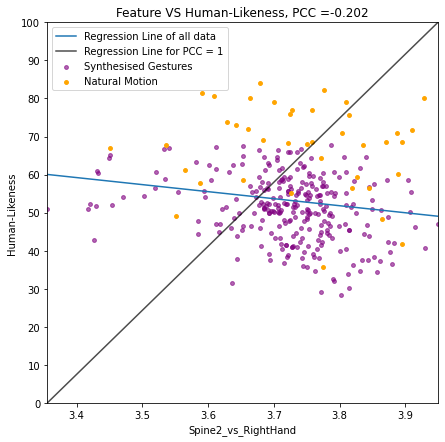

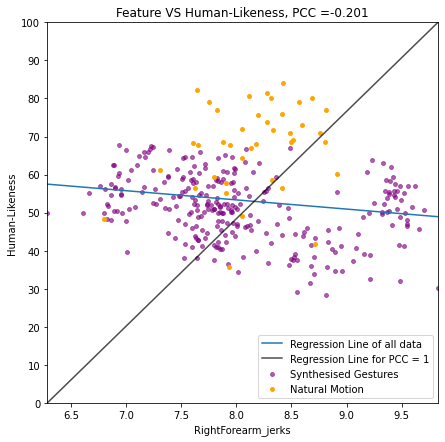

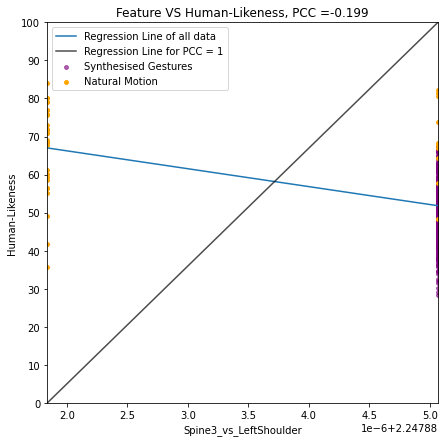

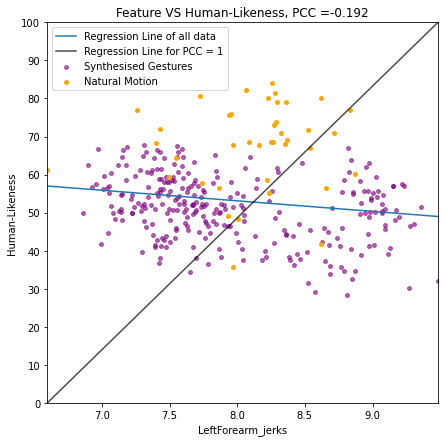

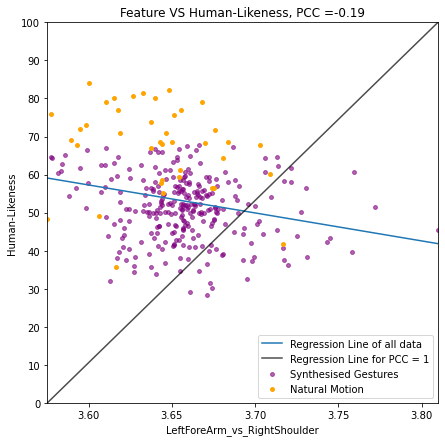

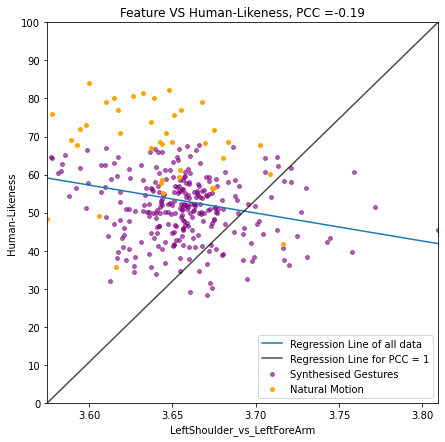

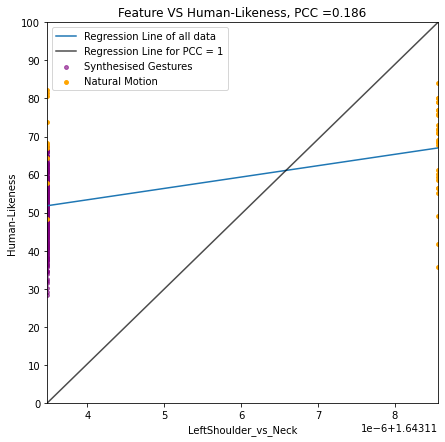

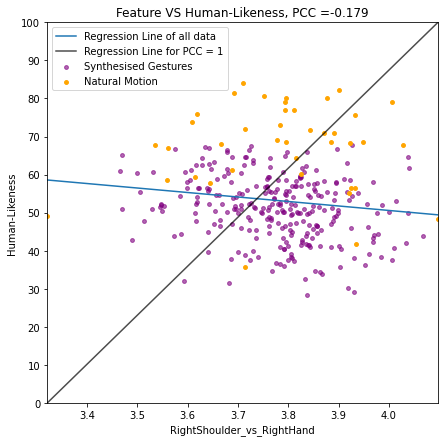

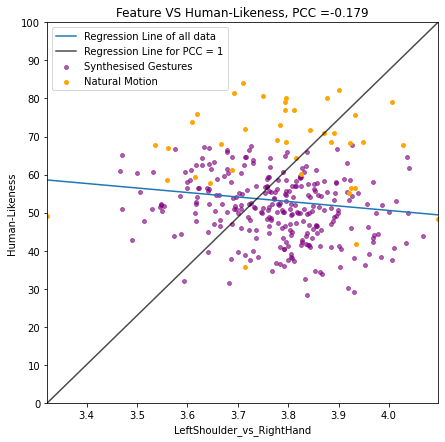

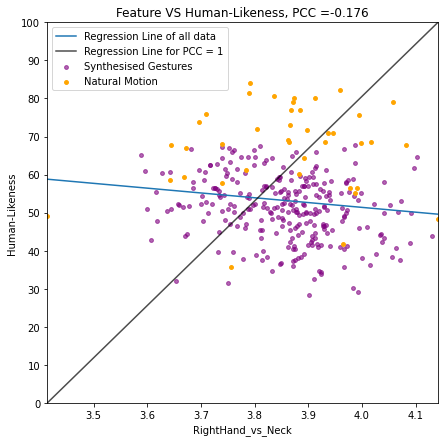

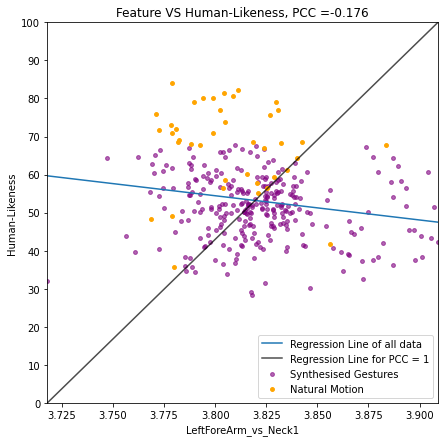

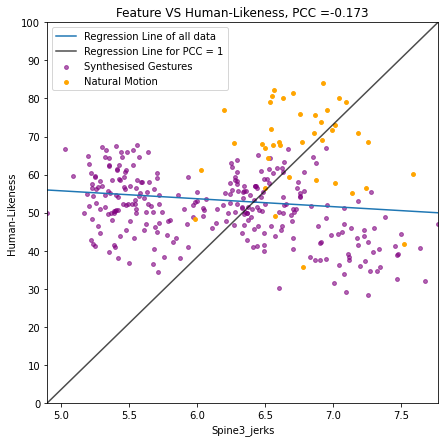

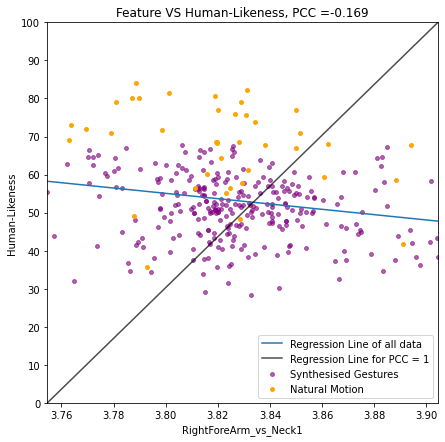

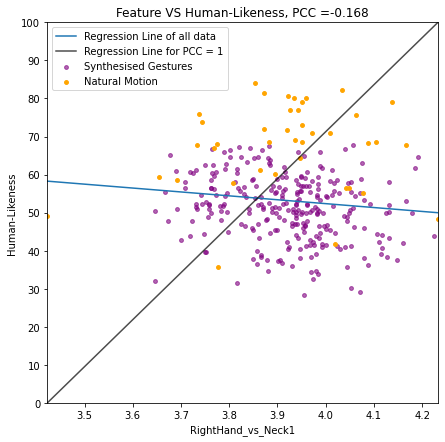

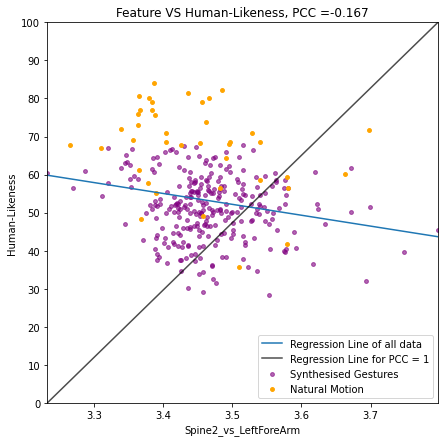

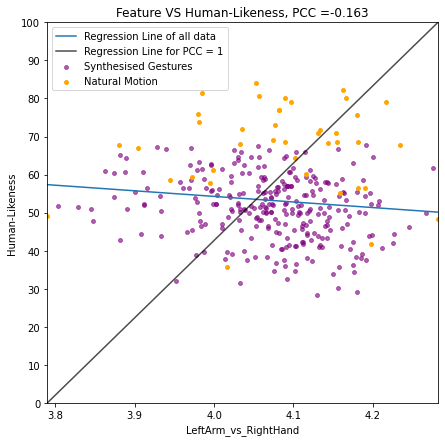

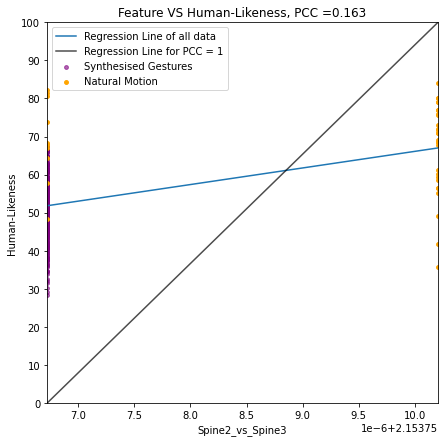

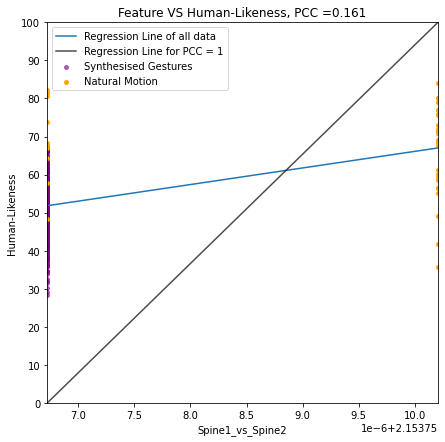

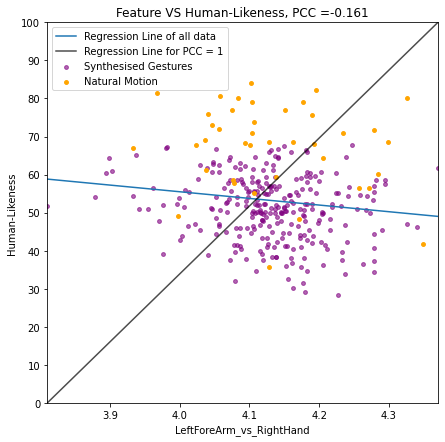

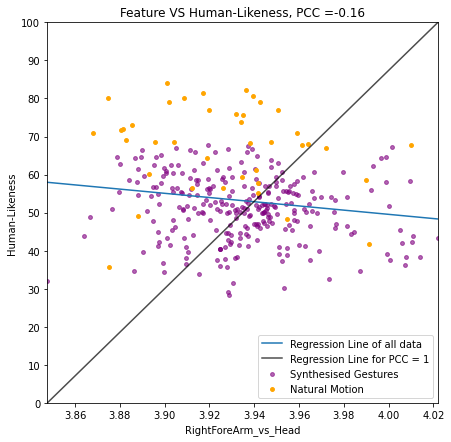

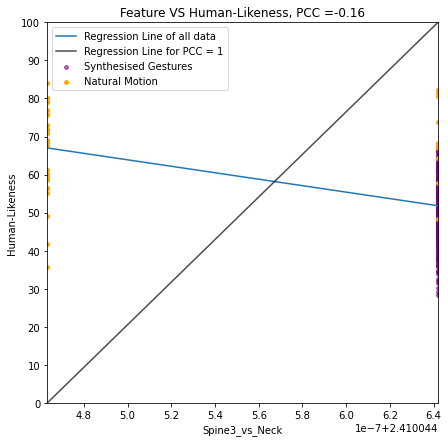

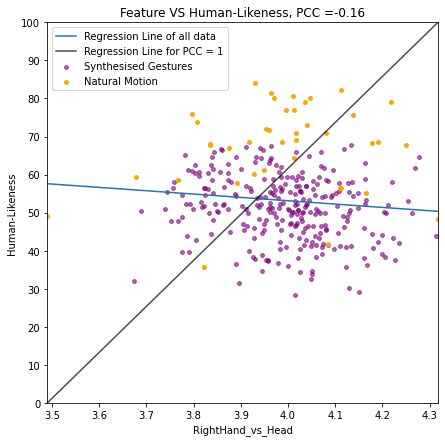

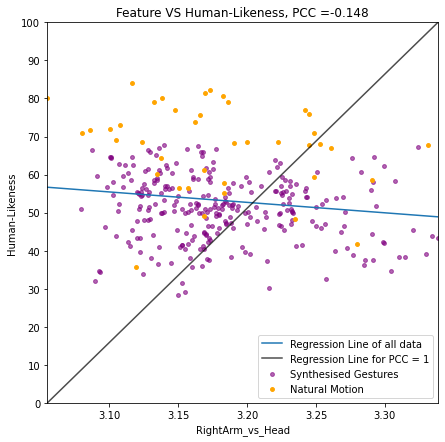

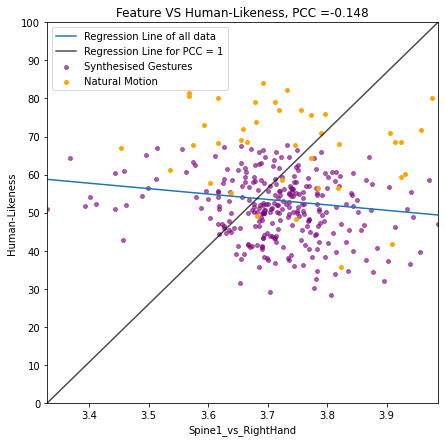

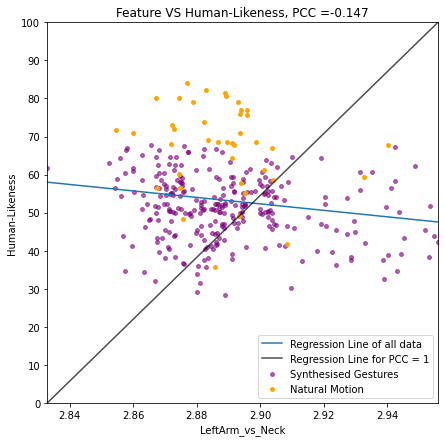

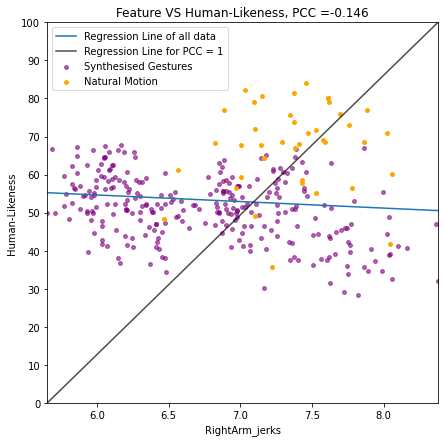

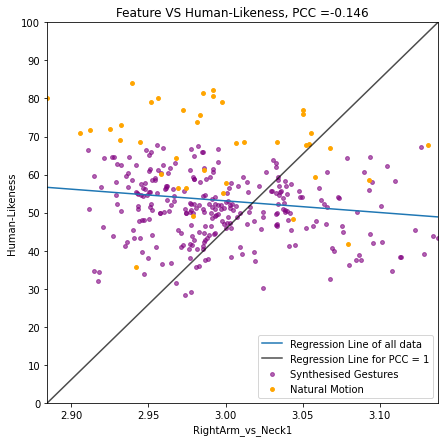

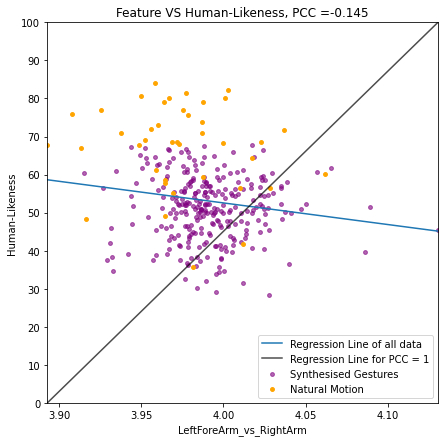

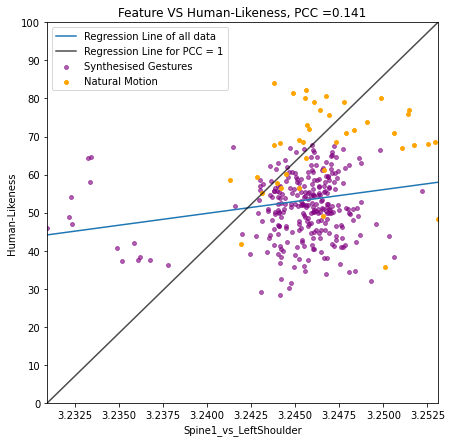

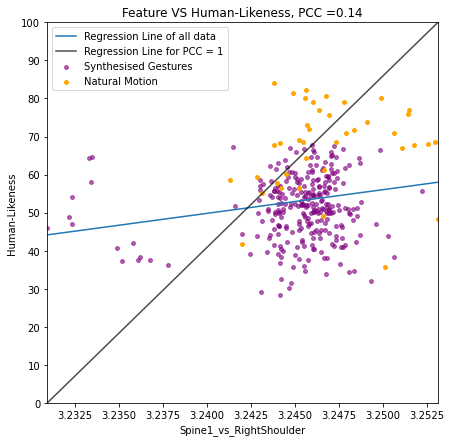

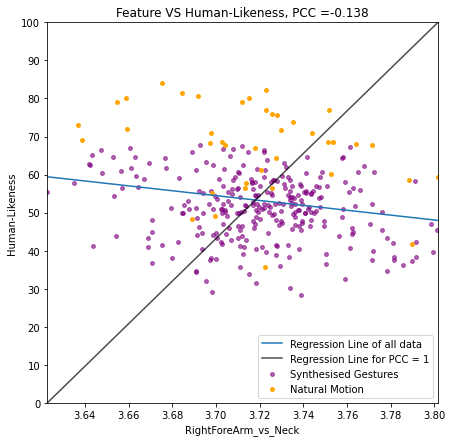

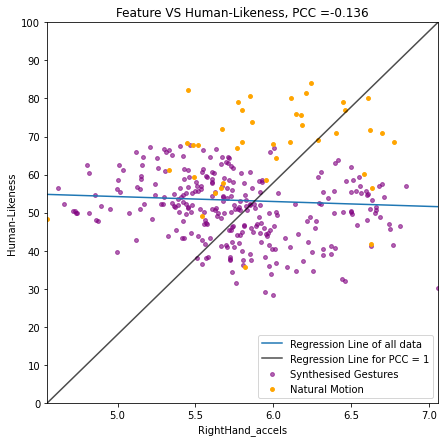

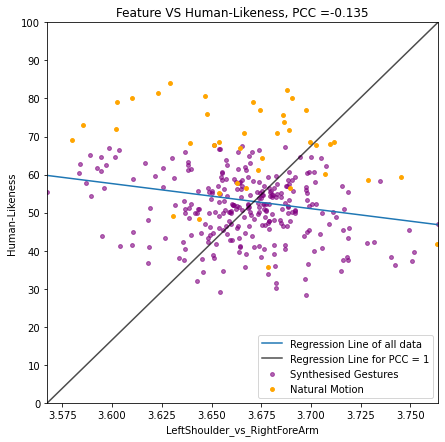

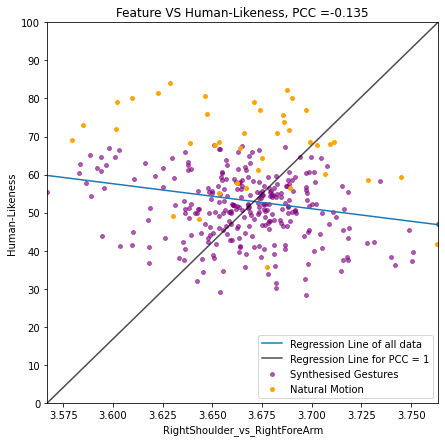

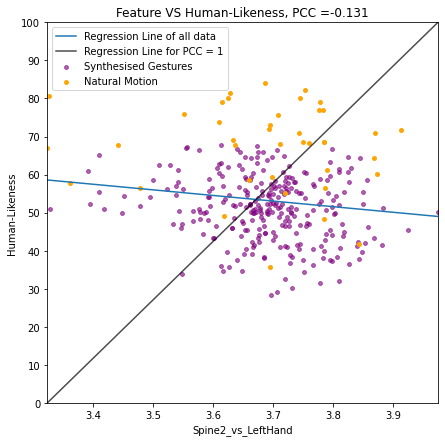

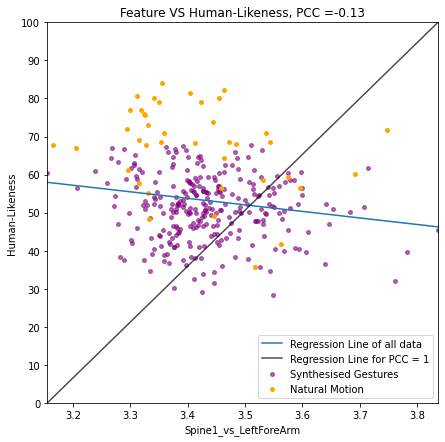

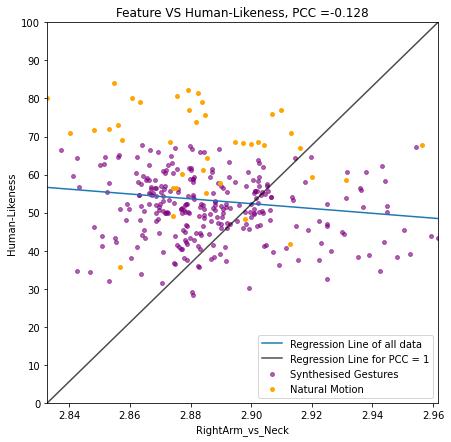

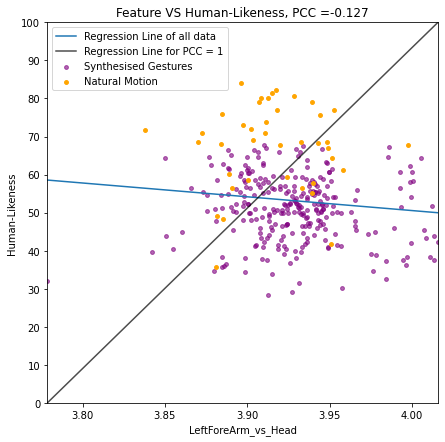

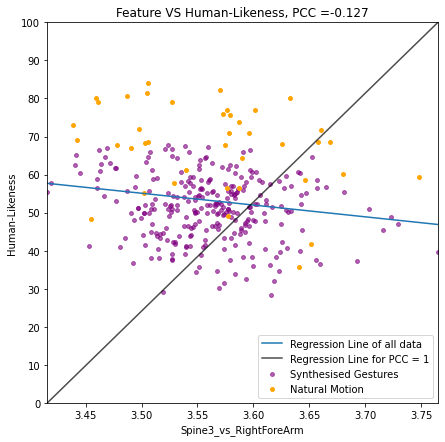

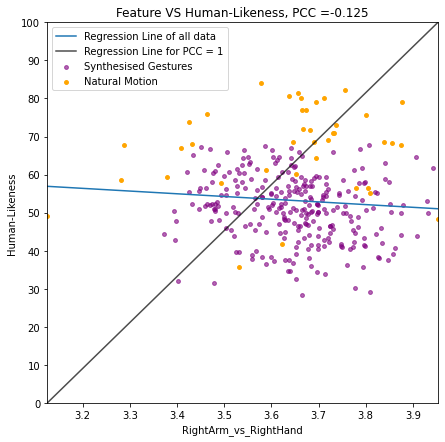

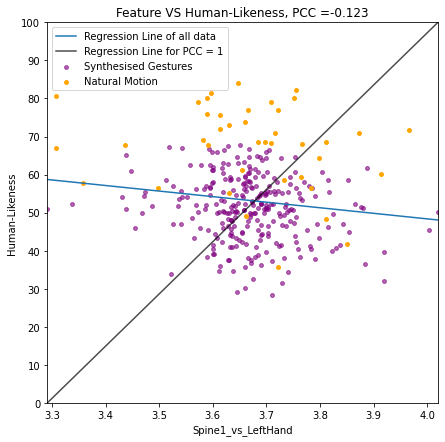

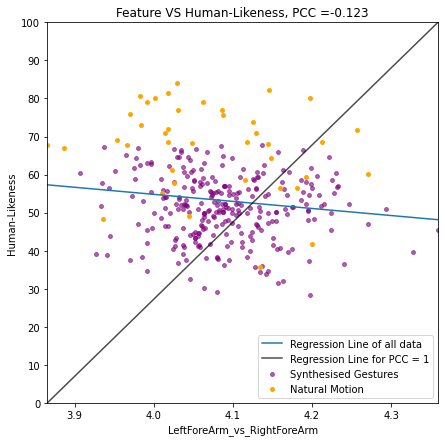

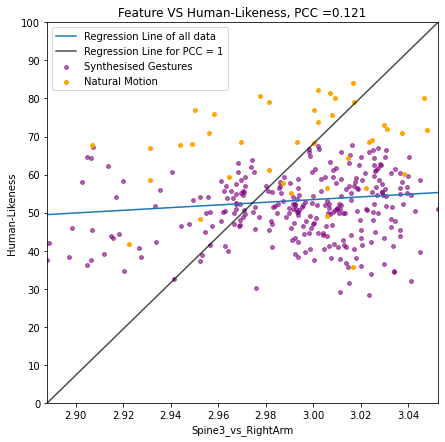

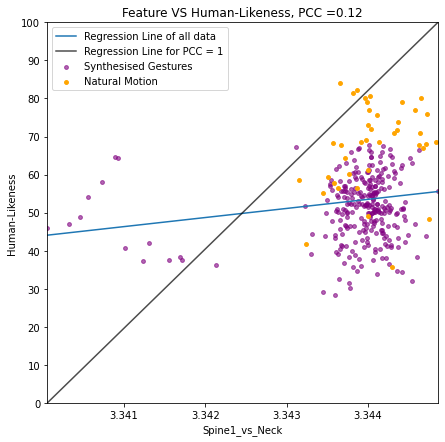

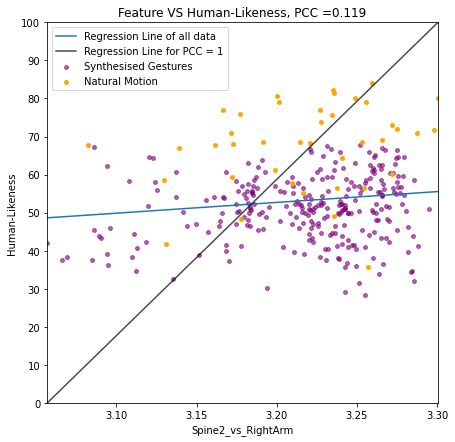

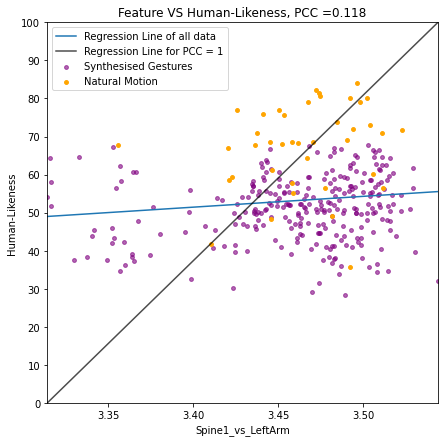

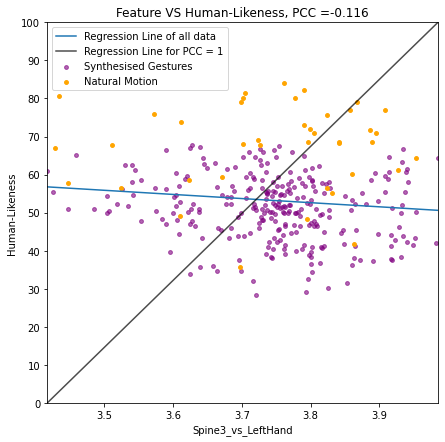

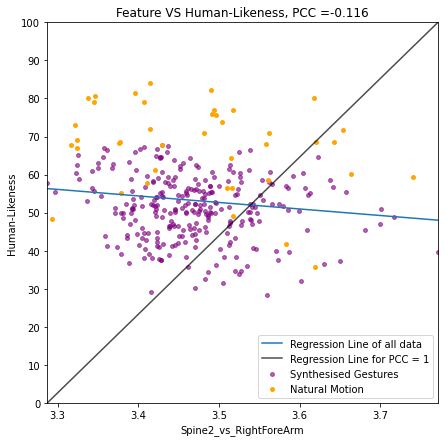

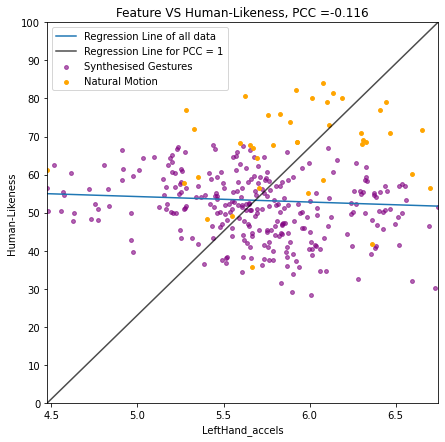

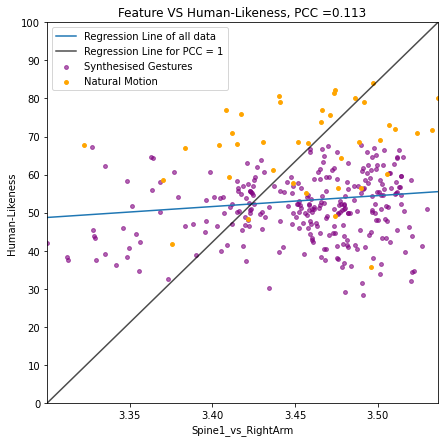

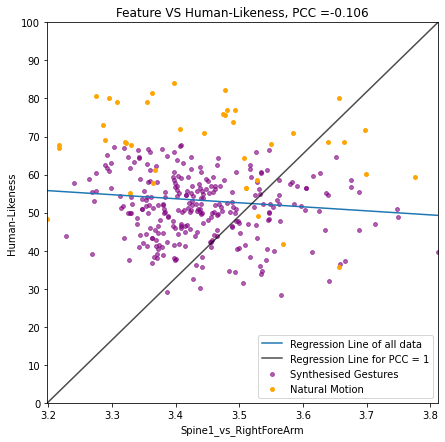

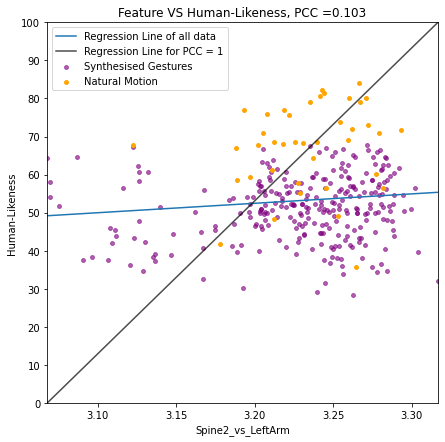

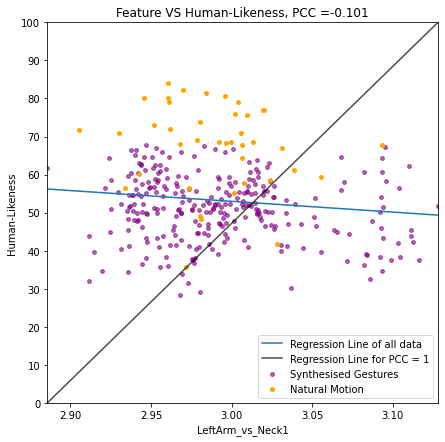

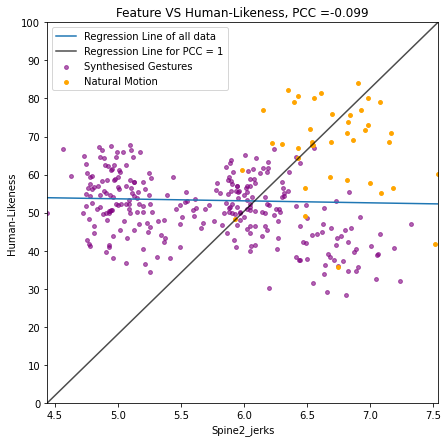

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


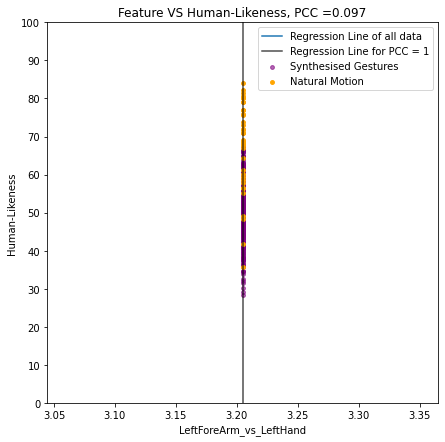

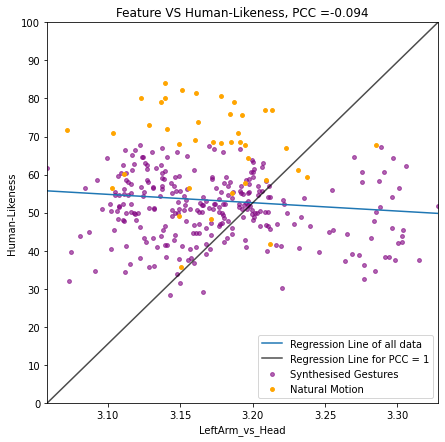

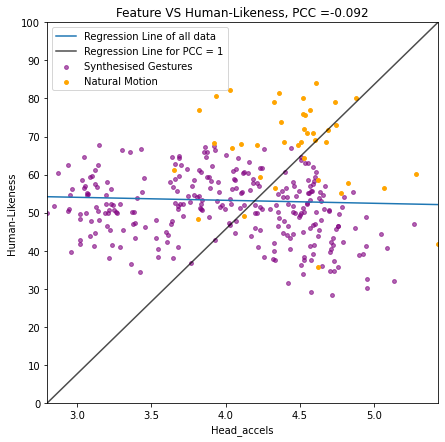

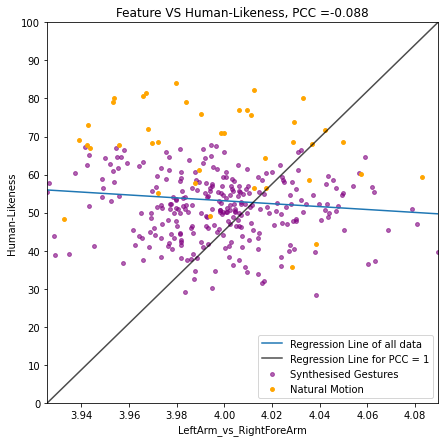

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


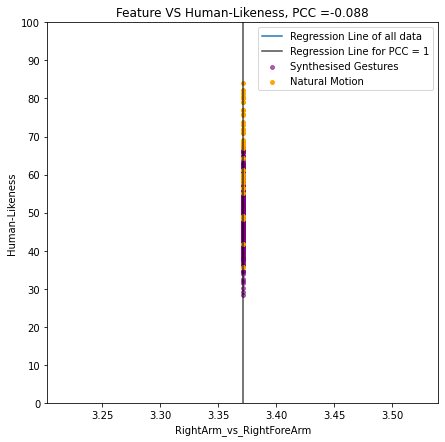

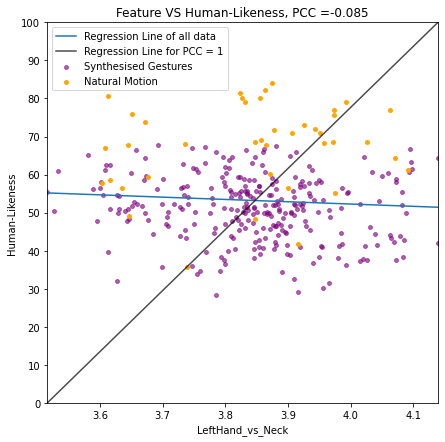

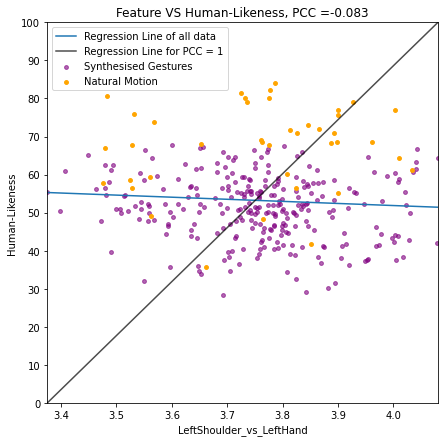

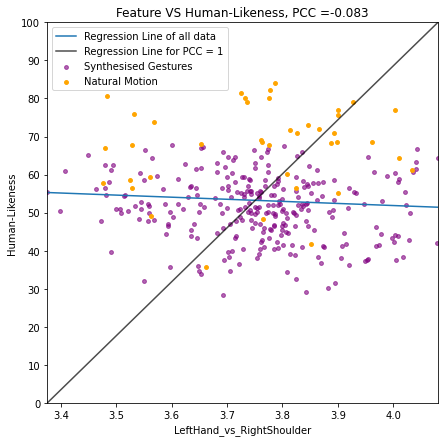

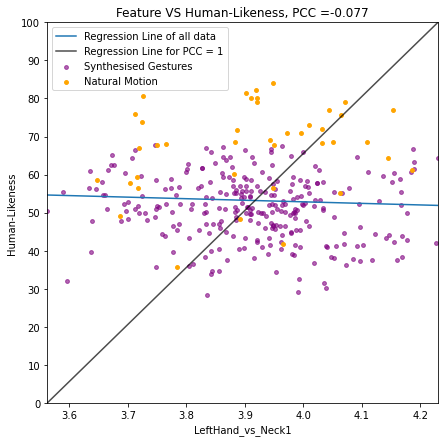

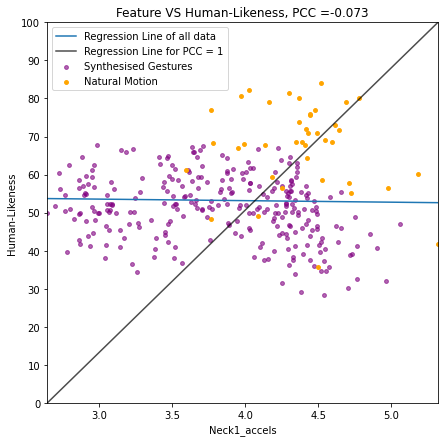

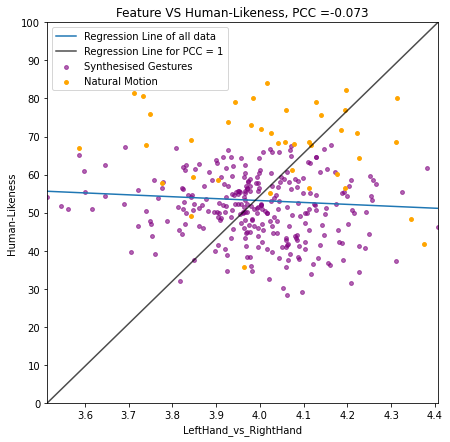

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


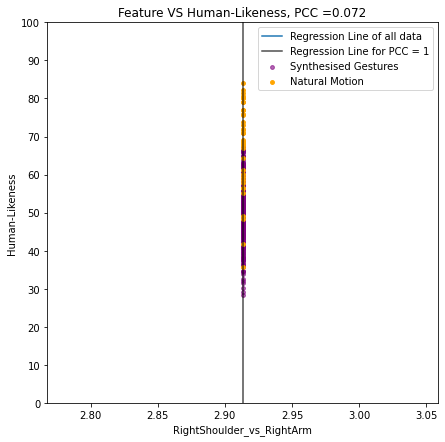

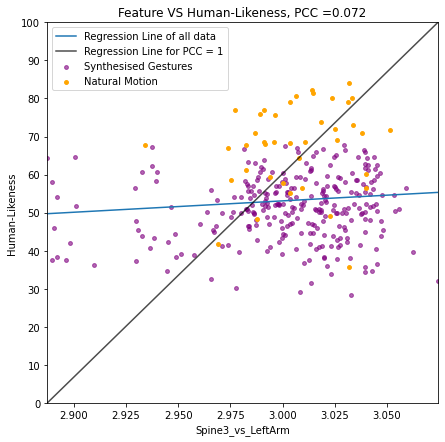

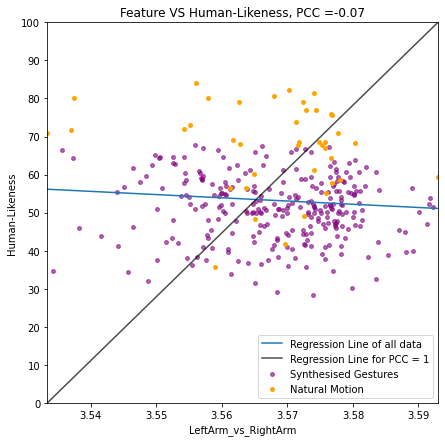

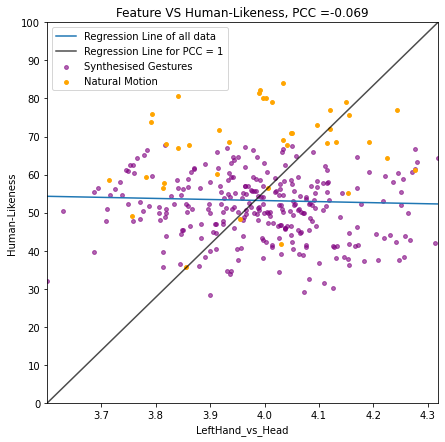

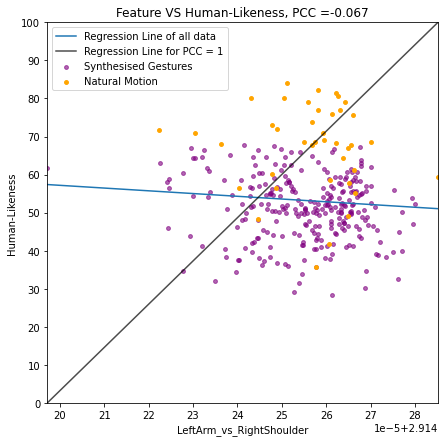

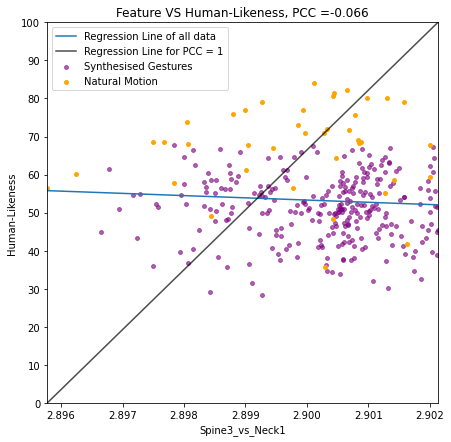

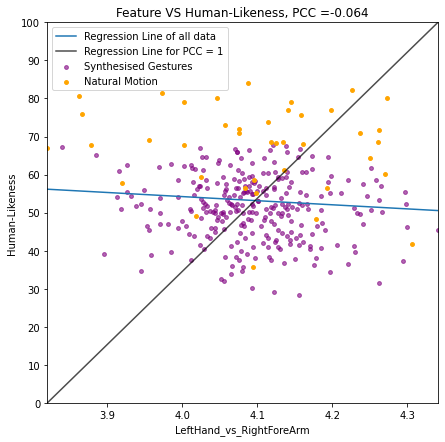

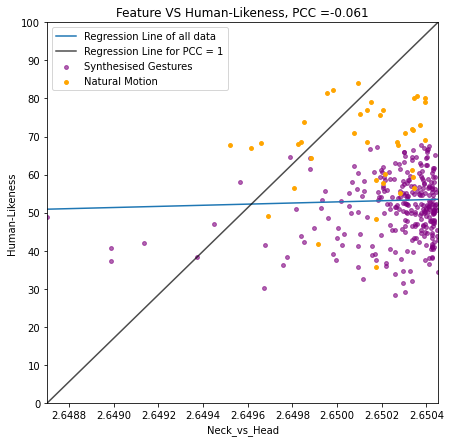

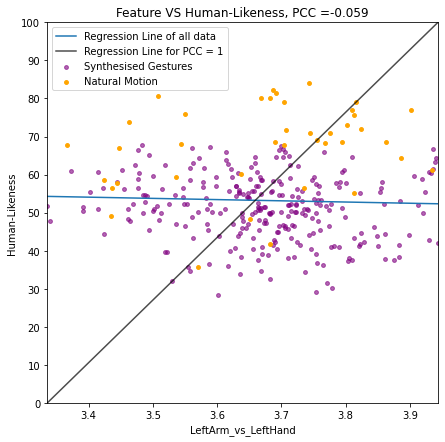

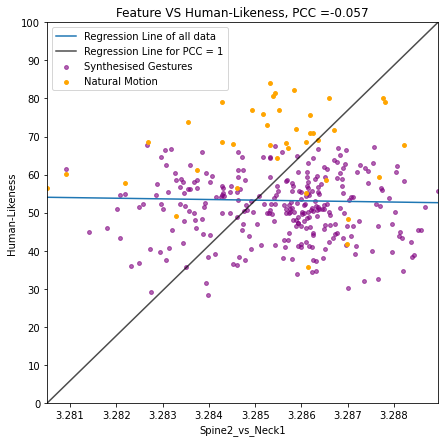

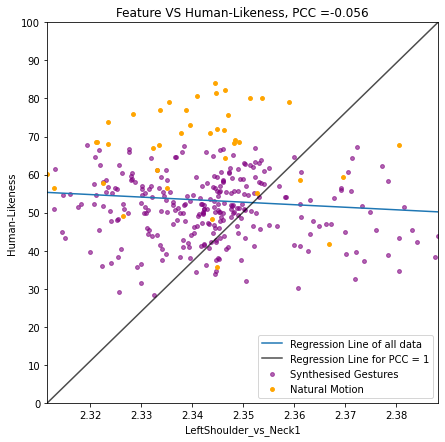

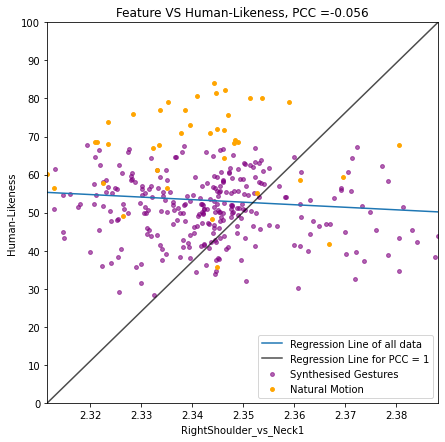

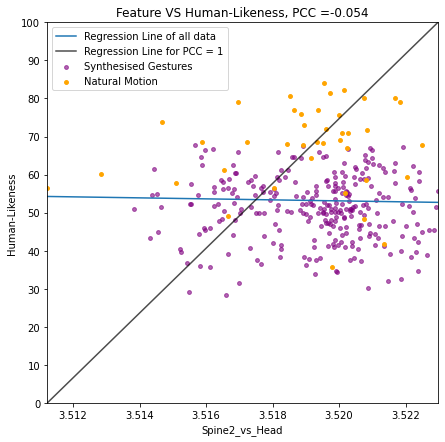

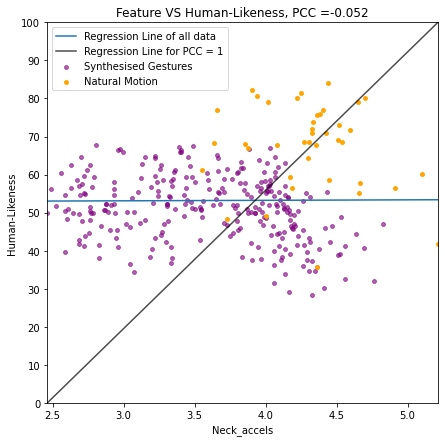

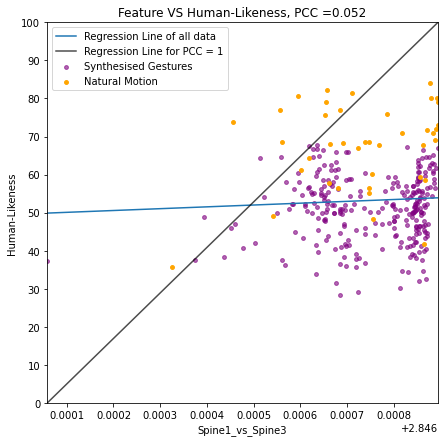

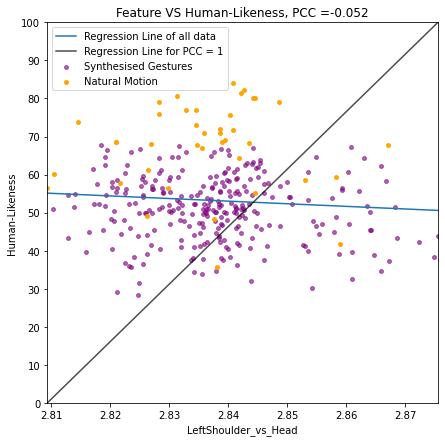

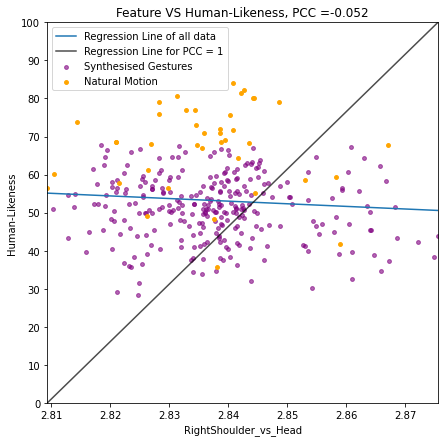

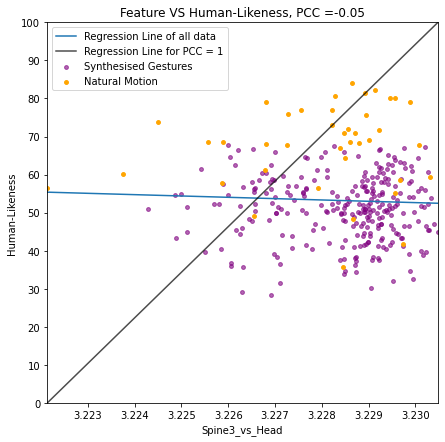

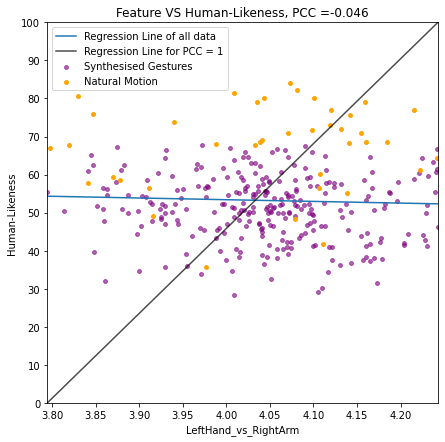

In [11]:
# Highest Plots
n = 100 # n highest plots
for i in range(0,n):
    idx = -1 - i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    m, b = np.polyfit(XX[feature], YY, 1)
    x = np.linspace(np.min(XX[feature]), np.max(XX[feature]), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line of all data")
    plt.plot(x, y, "-k", label="Regression Line for PCC = 1", alpha=0.7)
    plt.scatter(XX.loc[np.array(['Cond_N' not in idx for idx in XX.index])][feature], 
                YY.loc[np.array(['Cond_N' not in idx for idx in YY.index])], 
                s=15, c='purple', alpha=0.6, label='Synthesised Gestures')
    plt.scatter(XX.loc[['Cond_N' in idx for idx in XX.index]][feature], YY.loc[['Cond_N' in idx for idx in YY.index]], s=15, c='orange',
               label='Natural Motion')
    
    plt.ylim(0,100)
    plt.xlim(min(XX[feature]), max(XX[feature]))
    plt.ylabel('Human-Likeness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Human-Likeness, PCC =" + str(round(pcc,3)))
    plt.legend()
    plt.show()

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


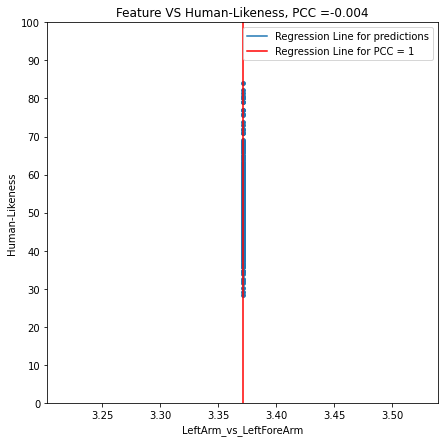

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


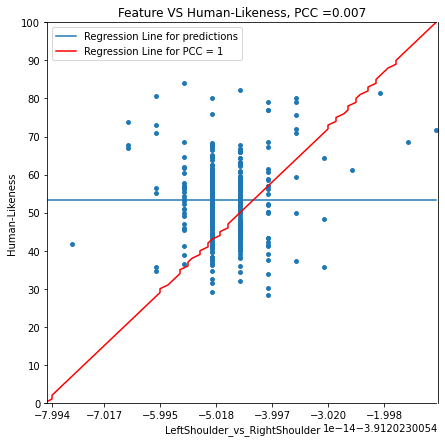

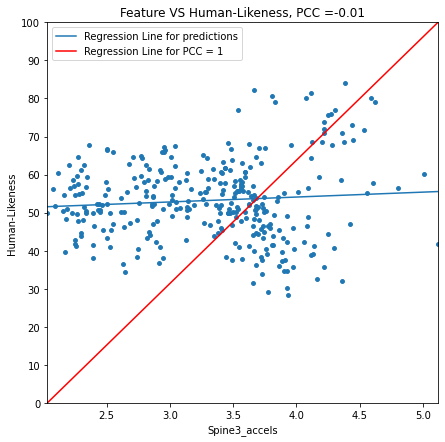

In [47]:
# Lowest Plots
n = 3 # n lowest plots
for i in range(0,n):
    idx = 0 + i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    m, b = np.polyfit(XX[feature], YY, 1)
    x = np.linspace(np.min(XX[feature]), np.max(XX[feature]), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line for predictions")
    plt.plot(x, y, "-r", label="Regression Line for PCC = 1")
    plt.scatter(XX[feature], YY, s=15)
    plt.xlim(min(XX[feature]), max(XX[feature]))
    plt.ylim(0,100)
    plt.ylabel('Human-Likeness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Human-Likeness, PCC =" + str(round(pcc,3)))
    plt.legend()
    plt.show()

Text(0, 0.5, 'RightHand_jerks')

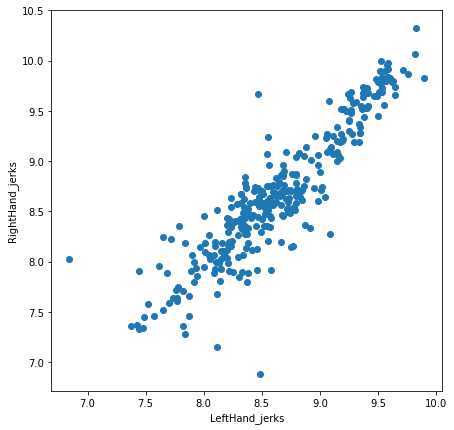

In [48]:
plt.figure(figsize = (7,7))
plt.scatter(XX['LeftHand_jerks'], XX['RightHand_jerks'])
plt.xlabel('LeftHand_jerks')
plt.ylabel('RightHand_jerks')

Text(0, 0.5, 'Neck_vs_Neck1')

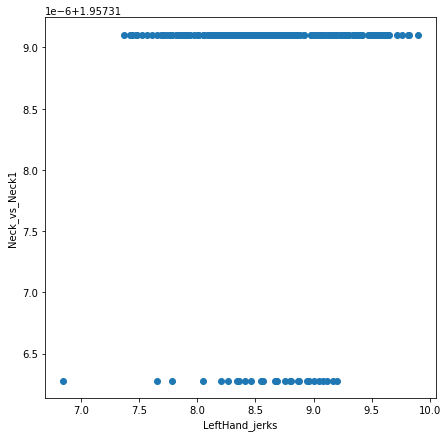

In [49]:
plt.figure(figsize = (7,7))
plt.scatter(XX['LeftHand_jerks'], XX['Neck_vs_Neck1'])
plt.xlabel('LeftHand_jerks')
plt.ylabel('Neck_vs_Neck1')

Text(0, 0.5, 'Neck_vs_Neck1')

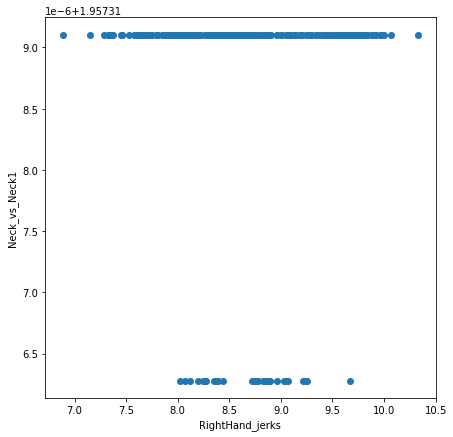

In [50]:
plt.figure(figsize = (7,7))
plt.scatter(XX['RightHand_jerks'], XX['Neck_vs_Neck1'])
plt.xlabel('RightHand_jerks')
plt.ylabel('Neck_vs_Neck1')